# SAM test on the dataset
The test is based on the original code from SAM github code:
https://github.com/facebookresearch/segment-anything/tree/main

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

### Prepare dataset, dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

In [49]:
class SurfaceDefectsDataset(Dataset):
    """ 
    Custom dataset to read in images and corresponding labels for
    the Magnetic Tile Surface Defects data.
    
    The data looks like this:
    .jpg - jpg files are the images (h*w*c)
    .png - png files contains the segmentation mask (h*w*c)
    
    Arguments:
        data_path: Given path to the input images.
        clip_size: Since SAM needs images with size over 256 we need to exclude the smaller ones.
        device: Defined device for pytorch.
    """
    
    def __init__(self, data_path, clip_size:int=256, device=None):
        self.data_path = data_path
        self.clip_size = clip_size
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        self.image_paths = sorted([os.path.join(self.data_path, i) for i in os.listdir(data_path) if i.split('.')[-1] == "jpg"])
        self.label_paths = sorted([os.path.join(self.data_path, i) for i in os.listdir(data_path) if i.split('.')[-1] == "png"])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):        
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]        
        imname = image_path.split("/")[-1]
        lbname = label_path.split("/")[-1]

        try:
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            if (image.shape[0]<self.clip_size or image.shape[1]<self.clip_size):
                print(f"image {imname} has shape: {image.shape}")
                print("Skipping this image.")
                return None, None
            # SAM expects images as 3*h*w default cv2 is h*w*3
            image = self.crop_to_extent(image)
            image = torch.tensor(image).permute(2,0,1).to(self.device)

            label = np.expand_dims(cv2.imread(label_path, cv2.IMREAD_GRAYSCALE),-1)
            if (label.shape[0]<self.clip_size or label.shape[1]<self.clip_size):
                print(f"label {lbname} has shape: {label.shape}")
                print("Skipping this label.")
                return None, None
            label = self.crop_to_extent(label)
            label = torch.tensor(label).permute(2,0,1).to(self.device)
            label[label[:,:]>=1] = 1 # make it binary

            return image, label

        except Exception as e:
            print(f"Error occurred while processing data at index {idx}: {str(e)}")
            return None, None

    
    def crop_to_extent(self, image):
        """ Resize each image to a common extent given in self.clip_size. 
            Input image should be: h*w*c.
        """
        original_x = image.shape[1]
        original_y = image.shape[0]
        diff_x = int((original_x - self.clip_size)/2)
        diff_y = int((original_y - self.clip_size)/2)
        crop_img = image[diff_y:diff_y+self.clip_size, diff_x:diff_x+self.clip_size, :]
        return crop_img

    
# --------------------------
## Results showed that these 'blowhole' features can be segmented well
## later it might be interesting to try out the others too.
imgpath = "/kaggle/input/magnetic-tile-surface-defects/MT_Blowhole/Imgs"
test_data = SurfaceDefectsDataset(data_path=imgpath) 

# Filter out corrupted images with None values
test_data_filtered = [(image, label) for image, label in test_data if image is not None and label is not None]
print(f"\nThere are {len(test_data_filtered)}/{int(len(os.listdir(imgpath))/2)} images and labels with H and W > 256:")

test_loader = DataLoader(test_data_filtered, batch_size=8, drop_last=True)    
ims, lbs = next(iter(test_loader))
print(f"image shape: {ims.shape} label shape: {lbs.shape}")
print(f"data device: {ims.device}")

image exp1_num_108719.jpg has shape: (373, 248, 3)
Skipping this image.
image exp1_num_108889.jpg has shape: (373, 248, 3)
Skipping this image.
image exp1_num_262480.jpg has shape: (246, 196, 3)
Skipping this image.
image exp1_num_297464.jpg has shape: (270, 213, 3)
Skipping this image.
image exp1_num_308015.jpg has shape: (272, 221, 3)
Skipping this image.
image exp1_num_317483.jpg has shape: (269, 218, 3)
Skipping this image.
image exp1_num_322605.jpg has shape: (257, 204, 3)
Skipping this image.
image exp1_num_36290.jpg has shape: (281, 117, 3)
Skipping this image.
image exp1_num_40410.jpg has shape: (290, 113, 3)
Skipping this image.
image exp1_num_4727.jpg has shape: (288, 113, 3)
Skipping this image.
image exp1_num_4944.jpg has shape: (282, 116, 3)
Skipping this image.
image exp1_num_51674.jpg has shape: (284, 112, 3)
Skipping this image.
image exp1_num_54246.jpg has shape: (278, 116, 3)
Skipping this image.
image exp2_num_262572.jpg has shape: (231, 187, 3)
Skipping this image.


# SAM prompting
source code: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

In [50]:
# Viz utils
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

def show_anns(ori_image, anns, ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.imshow(ori_image)
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [52]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

## ViT L has shown better results (312M params) - vitb (93.7M params)
# sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth"
model_type = "vit_l" # vit_b

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam.to(device=device)

predictor = SamPredictor(sam)
print(f"model device: {sam.device}")

model device: cuda:0


### Test on 1 sample

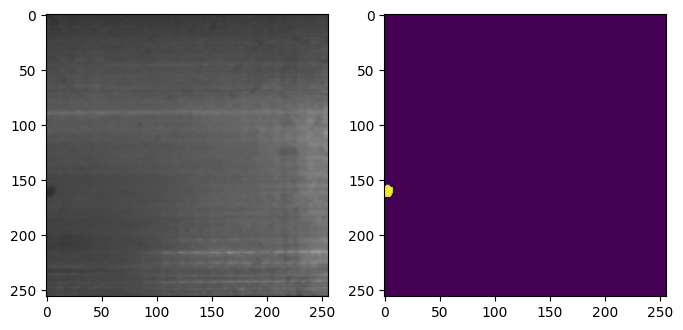

In [53]:
# image/label shape: bs*c*h*w
# but for plt viz we need h*w*c
ims, lbs = next(iter(test_loader))
index = 3
image = ims[index].cpu().numpy()
label = lbs[index].cpu().numpy()
image_to_viz = ims[index].cpu().numpy().swapaxes(0,-1)
label_to_viz = lbs[index].cpu().numpy().swapaxes(0,-1)

fig, axs = plt.subplots(1,2,figsize=(8,8))
axs[0].imshow(image_to_viz)
axs[1].imshow(label_to_viz)
plt.axis('on')
plt.show()

In [54]:
print(f"image shape: {image.shape}")
print(f"label shape: {label.shape}")
print(f"image_to_viz shape: {image_to_viz.shape}")
print(f"label_to_viz shape: {label_to_viz.shape}")

image shape: (3, 256, 256)
label shape: (1, 256, 256)
image_to_viz shape: (256, 256, 3)
label_to_viz shape: (256, 256, 1)


In [55]:
# SAM need bs*ch*h*w
image = image.swapaxes(0,-1)
# label = np.expand_dims(label[0,:,:],0) # lb to be: bs*1*h*w

predictor.set_image(image)
print(image.shape, label.shape)

masks, scores, logits = predictor.predict(
    mask_input=label,
    multimask_output=True,
)
print(masks.shape)

(256, 256, 3) (1, 256, 256)
(3, 256, 256)


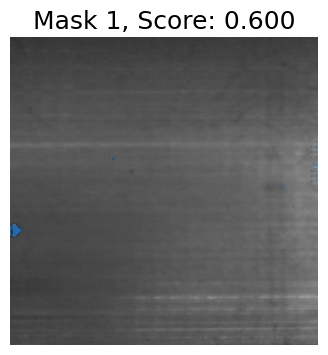

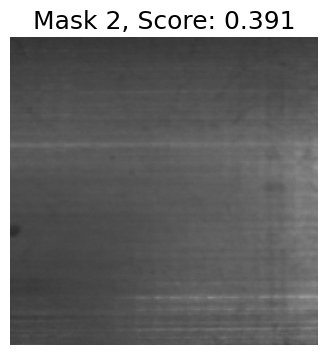

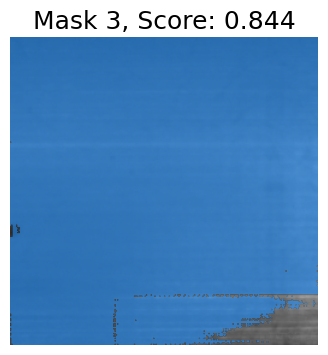

In [56]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

### Batch processing test

First testing inference with mask prompts only. Then I will adjust them with points derived from the mask itself to test if it produces a better result.

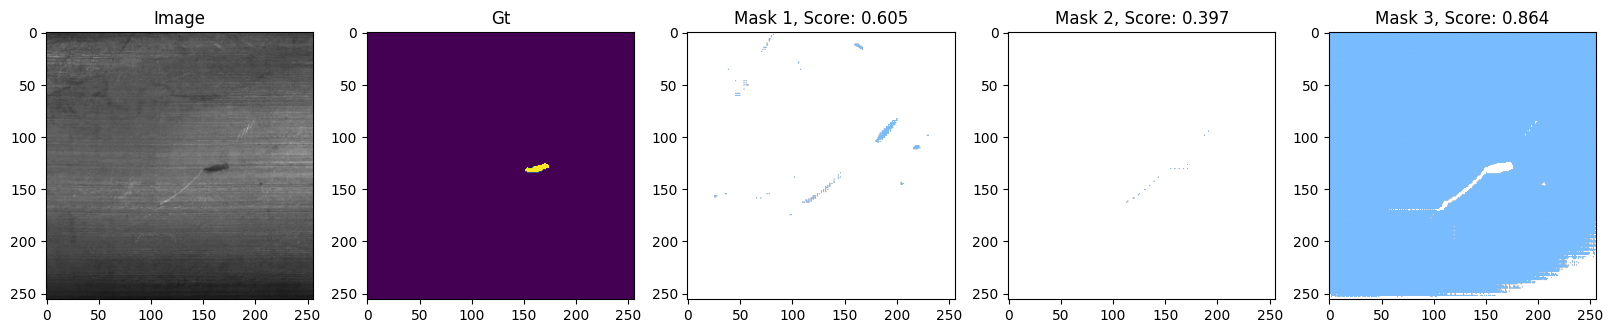

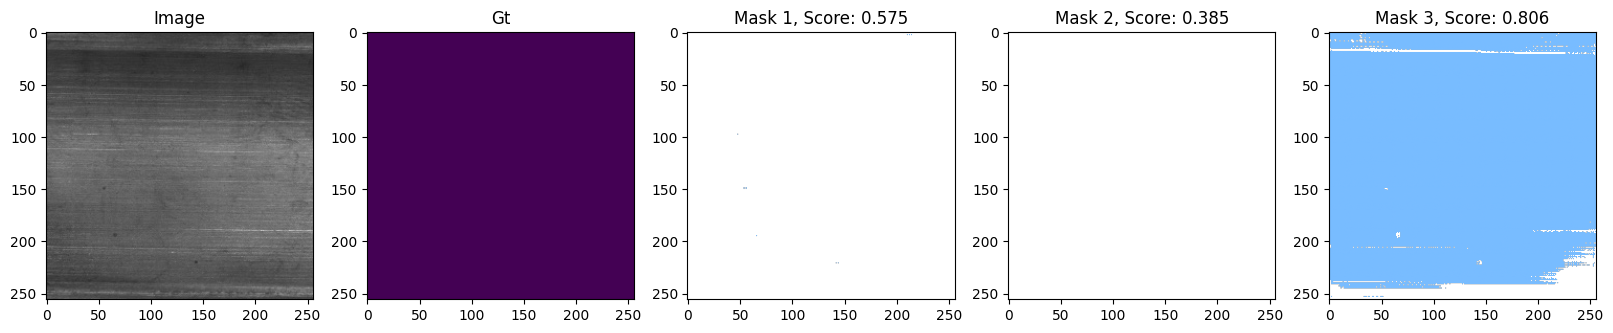

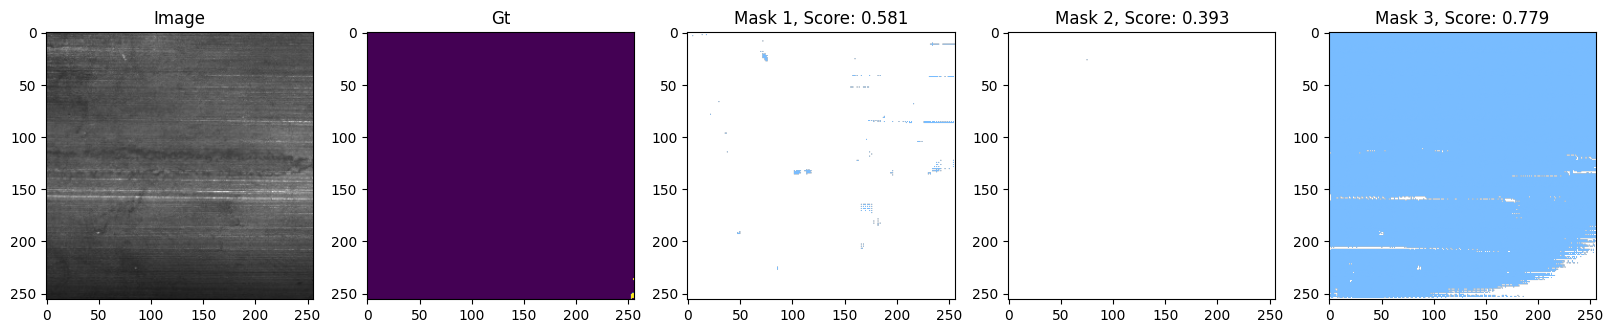

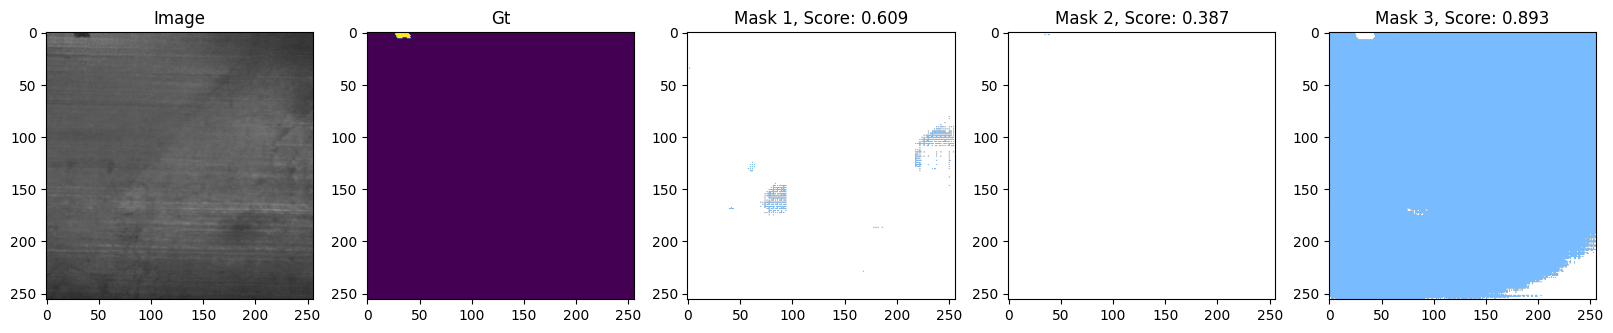

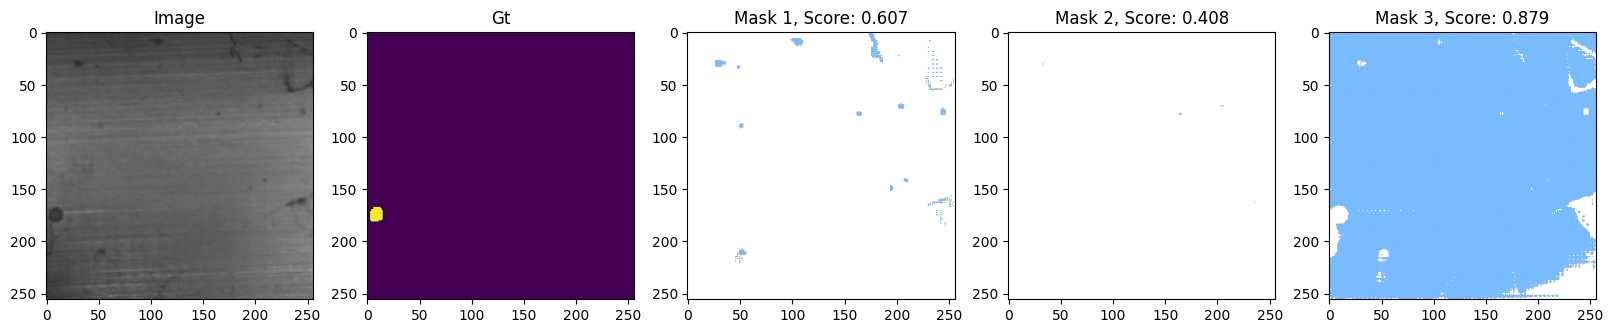

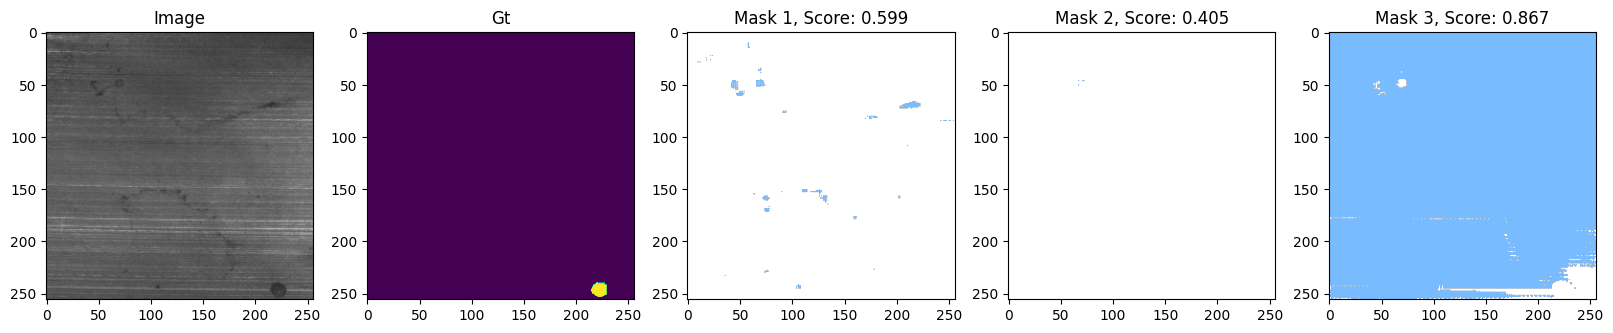

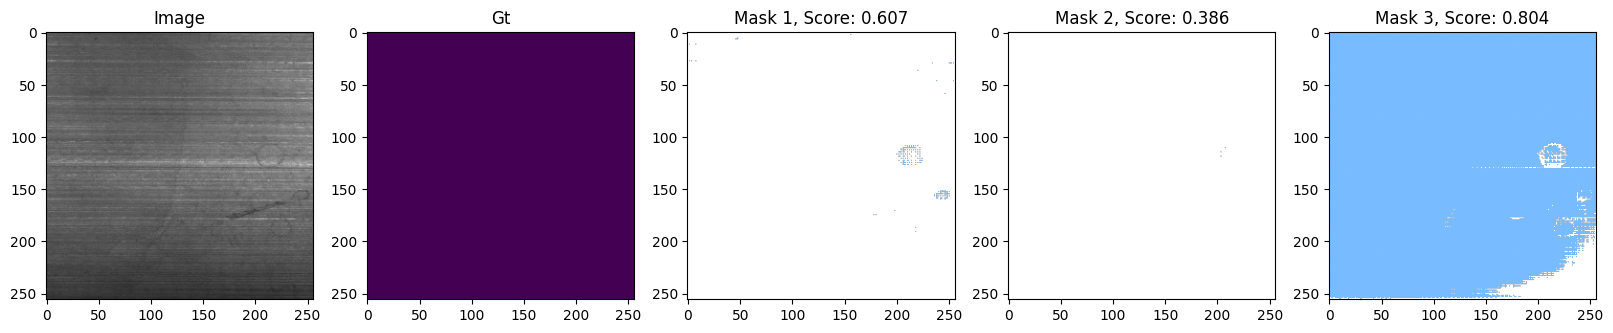

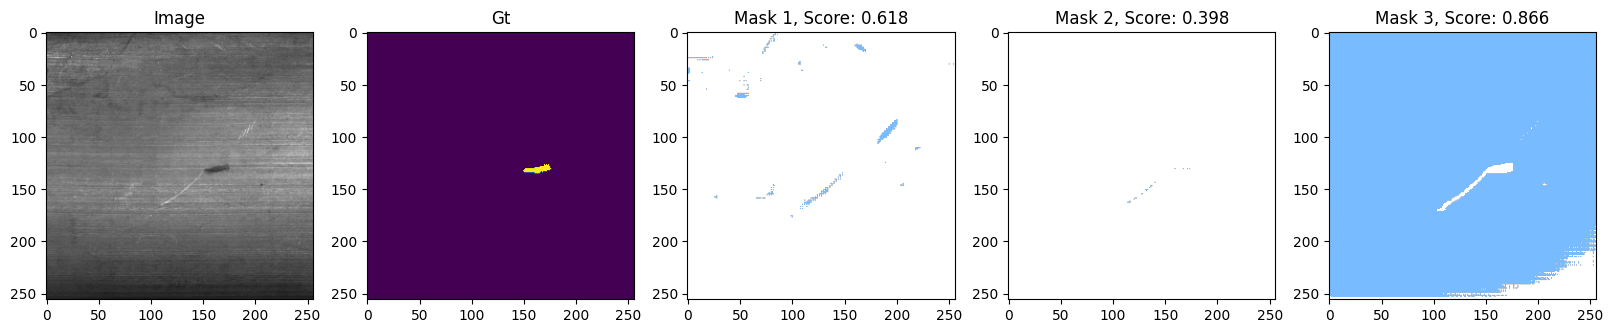

In [57]:
# SAM need bs*ch*h*w
def sam_prediction(image, label, predictor):
    image = image.cpu().numpy().swapaxes(0,-1)
    label = label.cpu().numpy()
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        mask_input=label,
        multimask_output=True, # in this case SAM outputs 3 pred mask
    )
    return masks, scores, logits

# Get data
iterator = iter(test_loader)
skip_first = next(iterator)
imgs, lbls = next(iterator)

# Viz
for im, lb in zip(imgs, lbls):
    masks, scores, logits = sam_prediction(im, lb, predictor)
    im = im.cpu().numpy().swapaxes(0,-1)
    lb = lb.cpu().numpy().swapaxes(0,-1)

    fig, axs = plt.subplots(1,5, figsize=(20,8))
    axs[0].imshow(im)
    axs[0].set_title("Image")
    axs[1].imshow(lb)
    axs[1].set_title("Gt")
    show_mask(masks[0], ax=axs[2])
    axs[2].set_title(f"Mask 1, Score: {scores[0]:.3f}")
    show_mask(masks[1], ax=axs[3])
    axs[3].set_title(f"Mask 2, Score: {scores[1]:.3f}")
    show_mask(masks[2], ax=axs[4])
    axs[4].set_title(f"Mask 3, Score: {scores[2]:.3f}")
    plt.show()

### Test with multiple input prompts (points+mask)

In [58]:
# Get data
iterator = iter(test_loader)
skip_first = next(iterator)
imgs, lbls = next(iterator)

In [59]:
def select_n_points_on_mask(n_points, label):
    """ Find the given number of coordinate pairs of pixels on the mask image. """
    flat_label = label.flatten()
    if 1 in np.unique(label):
        indices_ones = np.where(flat_label == 1)[0]
        selected_indices = np.random.choice(indices_ones, size=n_points, replace=False)
        coords = np.unravel_index(selected_indices, label.shape[-2:]) # back to 2D
        selected_coords = np.array([[coord_x, coord_y] for coord_x, coord_y in zip(coords[0], coords[1])])
        selected_labels = np.array([1 for _ in range(n_points)])
        return selected_coords, selected_labels
    else:
        return None, None

def sam_prediction(image, label, predictor, point_prompts=False):
    image = image.cpu().numpy().swapaxes(0,-1)
    label = label.cpu().numpy()
    predictor.set_image(image)
    
    if point_prompts:
        sel_points, sel_labels = select_n_points_on_mask(n_points=5, label=label)
        if sel_points is not None:
            print(f"Selected coords:\n{sel_points}")
            masks, scores, logits = predictor.predict(
                point_coords=sel_points,
                point_labels=sel_labels,
                mask_input=label,
                multimask_output=True,)
        else:            
            print("Label has no true values. Just 'segment anything'...")
            masks, scores, logits = predictor.predict(
                mask_input=label,
                multimask_output=True)
    else:
        masks, scores, logits = predictor.predict(
            mask_input=label,
            multimask_output=True)
    
    return masks, scores, logits


Selected coords:
[[171 127]
 [153 134]
 [161 133]
 [171 129]
 [169 126]]


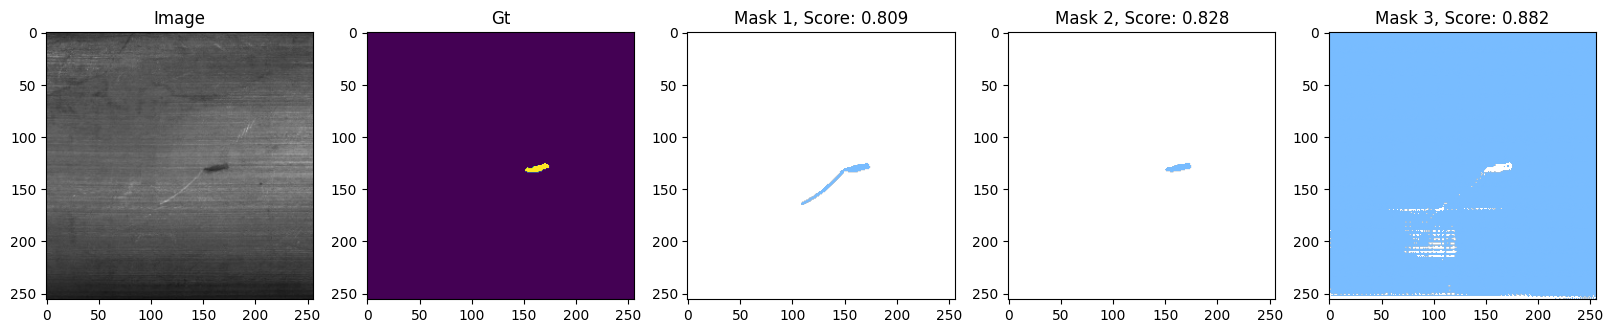

Label has no true values. Just 'segment anything'...


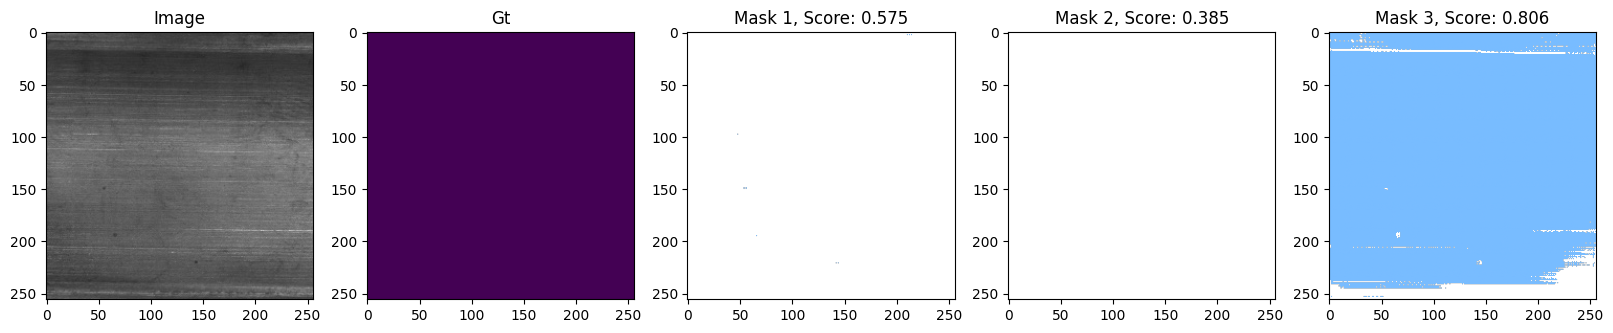

Selected coords:
[[254 251]
 [255 236]
 [255 251]
 [255 239]
 [254 236]]


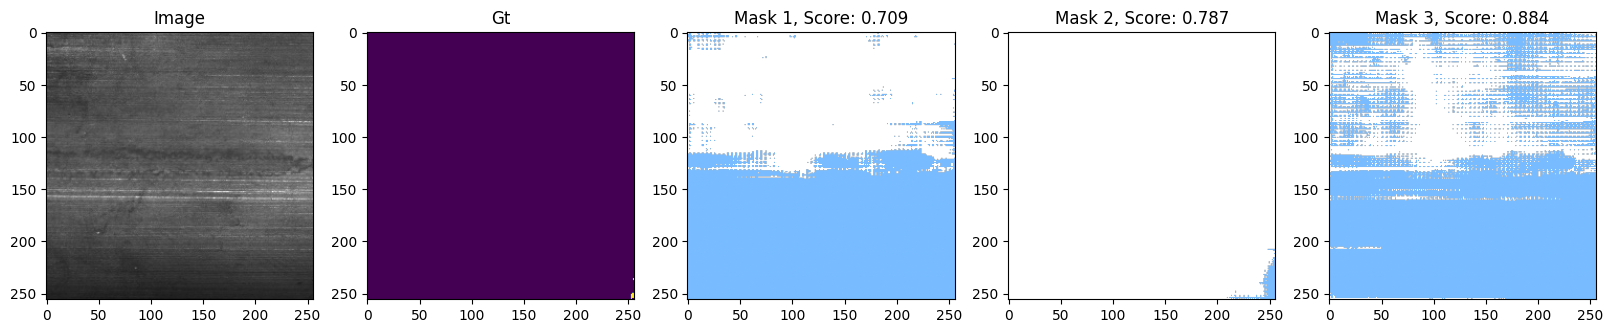

Selected coords:
[[37  2]
 [30  3]
 [38  1]
 [40  6]
 [38  0]]


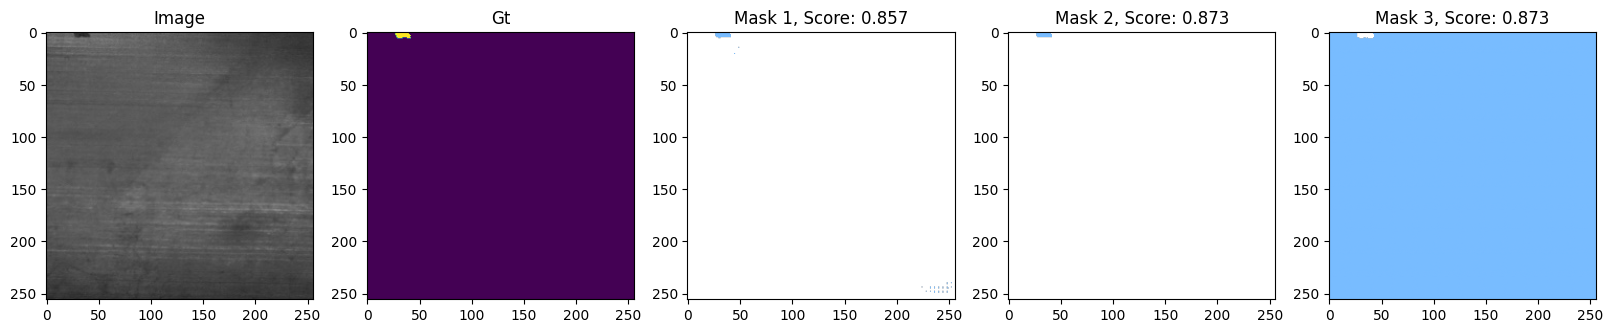

Selected coords:
[[  4 171]
 [  5 177]
 [ 11 178]
 [ 11 169]
 [ 10 176]]


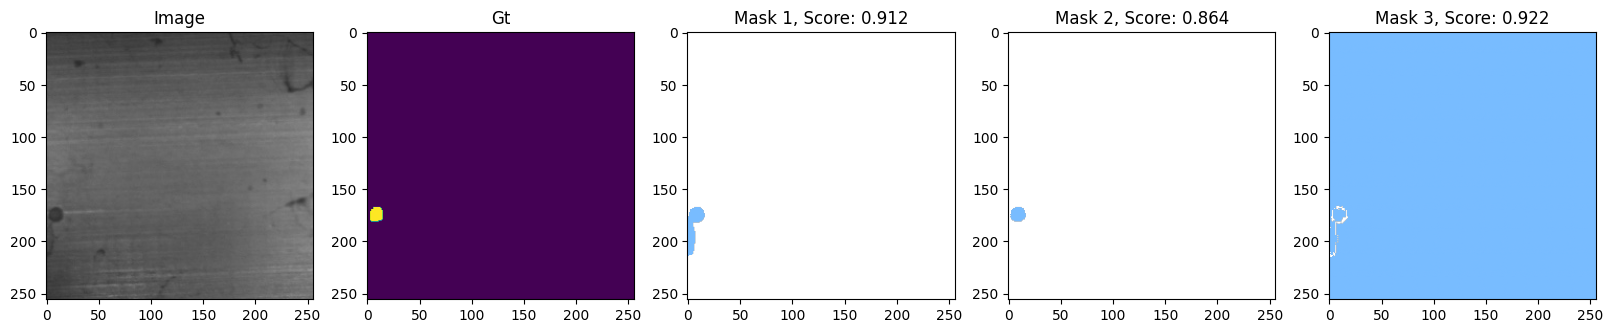

Selected coords:
[[220 245]
 [225 251]
 [215 250]
 [221 247]
 [216 248]]


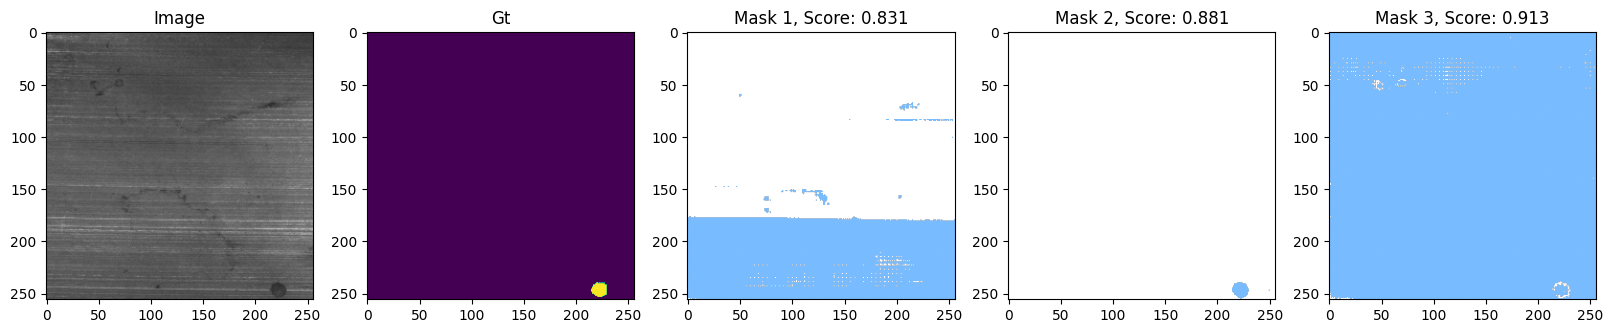

Label has no true values. Just 'segment anything'...


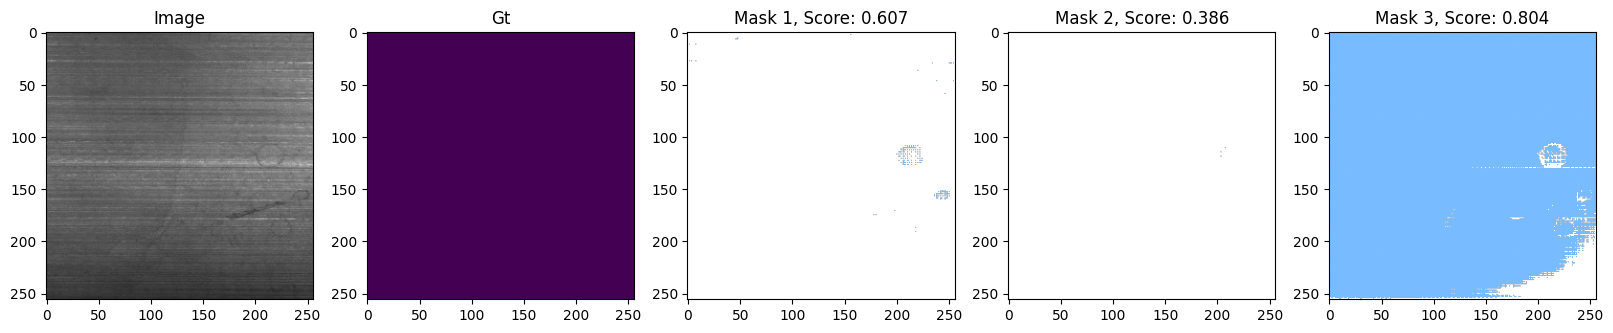

Selected coords:
[[152 134]
 [169 130]
 [160 135]
 [158 132]
 [152 133]]


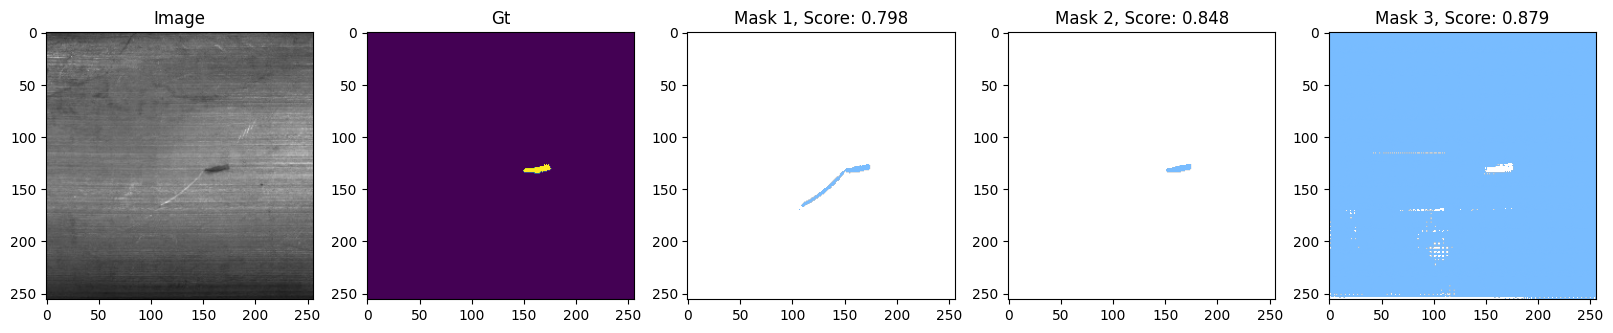

In [60]:
# Viz
for im, lb in zip(imgs, lbls):
    masks, scores, logits = sam_prediction(im, lb, predictor, point_prompts=True)
    im = im.cpu().numpy().swapaxes(0,-1)
    lb = lb.cpu().numpy().swapaxes(0,-1)

    fig, axs = plt.subplots(1,5, figsize=(20,8))
    axs[0].imshow(im)
    axs[0].set_title("Image")
    axs[1].imshow(lb)
    axs[1].set_title("Gt")
    show_mask(masks[0], ax=axs[2])
    axs[2].set_title(f"Mask 1, Score: {scores[0]:.3f}")
    show_mask(masks[1], ax=axs[3])
    axs[3].set_title(f"Mask 2, Score: {scores[1]:.3f}")
    show_mask(masks[2], ax=axs[4])
    axs[4].set_title(f"Mask 3, Score: {scores[2]:.3f}")
    plt.show()

Well that looks more promising on the second output mask, lets see another batch of data

Selected coords:
[[252 252]
 [253 243]
 [252 237]
 [251 251]
 [255 249]]


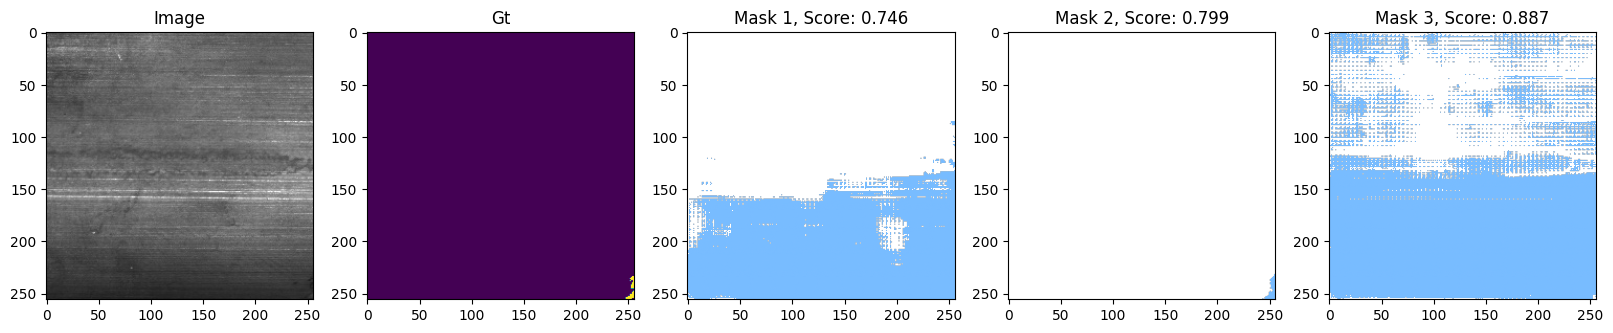

Selected coords:
[[33  4]
 [24  5]
 [26  1]
 [33  5]
 [26  2]]


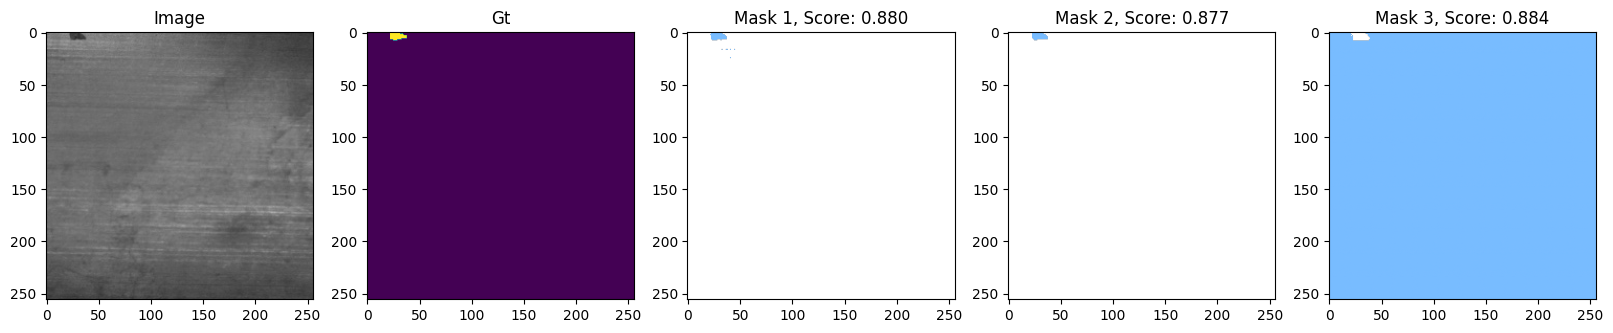

Selected coords:
[[  5 167]
 [  5 162]
 [  0 167]
 [  6 165]
 [  0 162]]


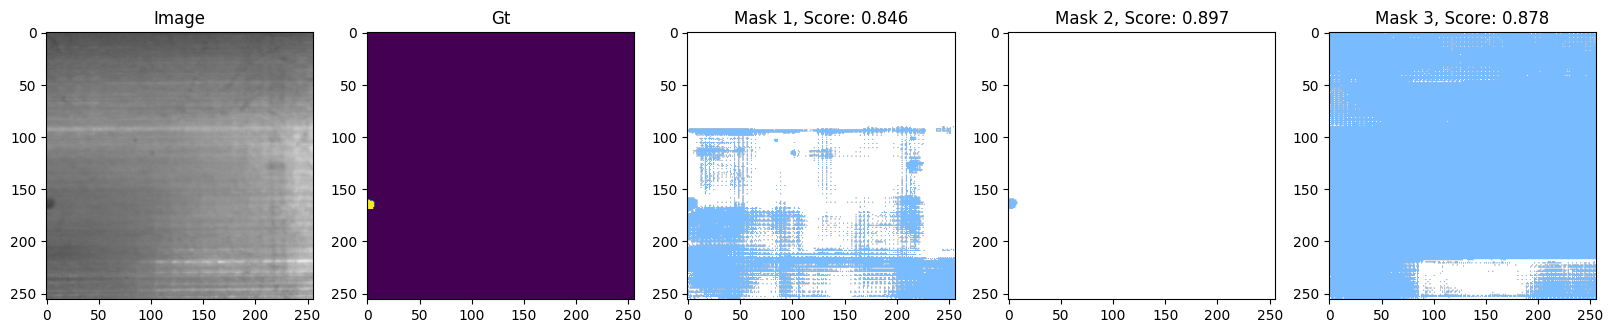

Selected coords:
[[  5 176]
 [  2 176]
 [  3 174]
 [  5 165]
 [  4 167]]


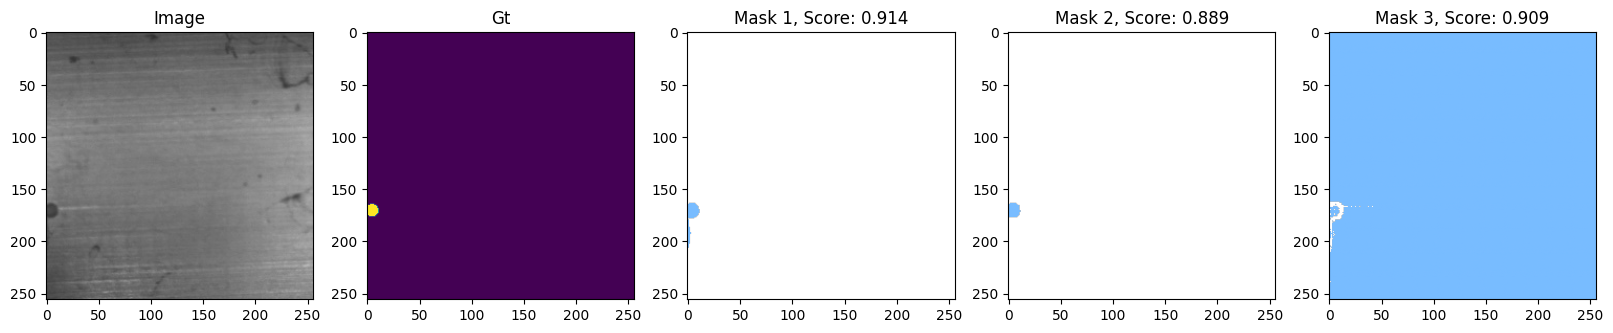

Selected coords:
[[218 243]
 [227 255]
 [216 246]
 [221 251]
 [219 253]]


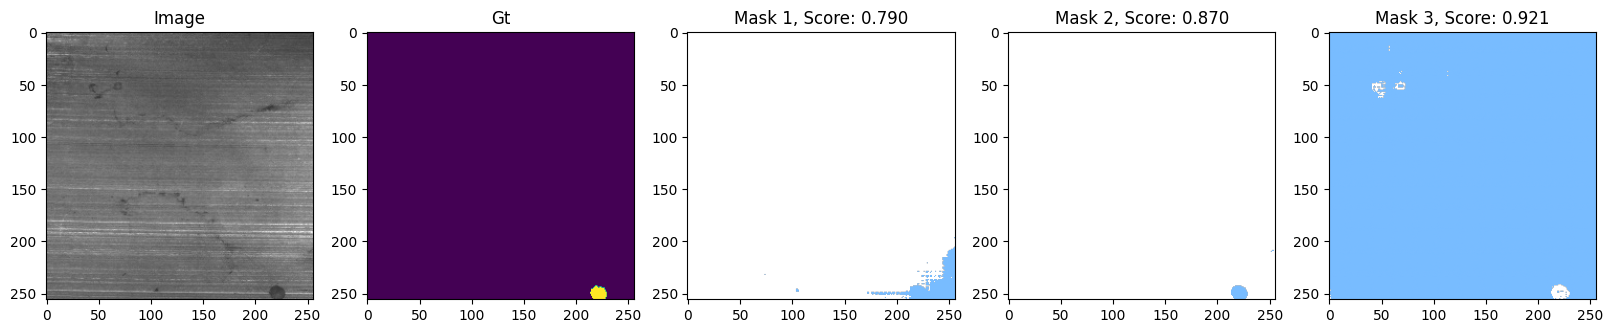

Label has no true values. Just 'segment anything'...


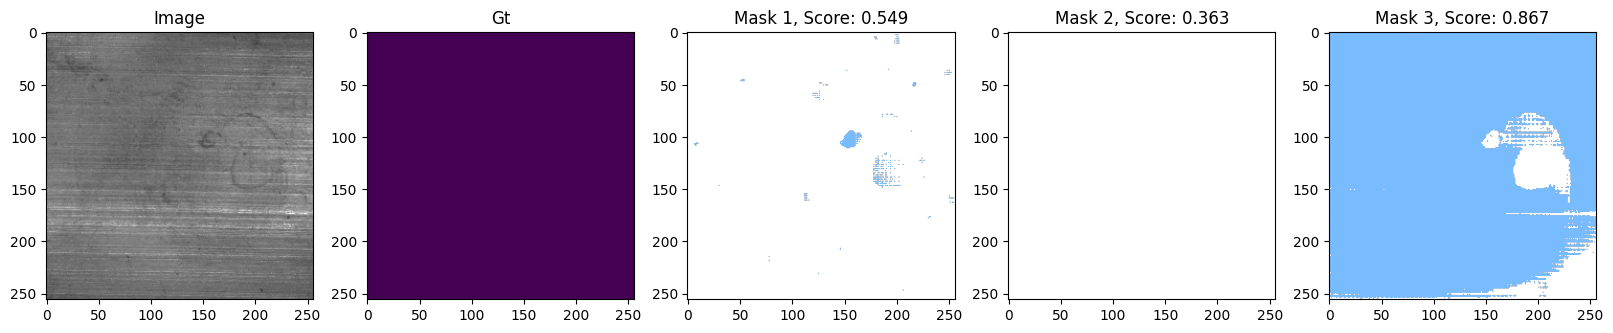

Label has no true values. Just 'segment anything'...


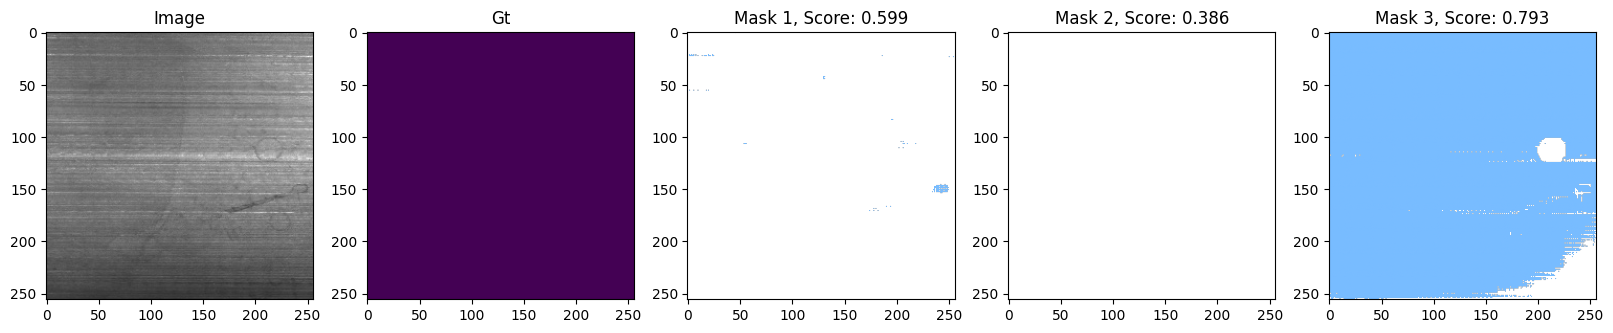

Label has no true values. Just 'segment anything'...


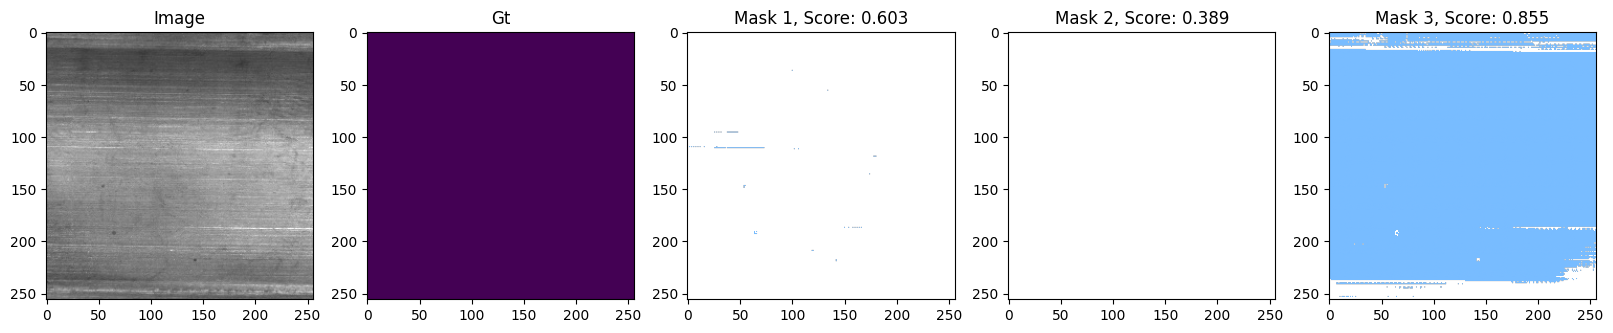

In [61]:
imgs, lbls = next(iterator)

# Viz
for im, lb in zip(imgs, lbls):
    masks, scores, logits = sam_prediction(im, lb, predictor, point_prompts=True)
    im = im.cpu().numpy().swapaxes(0,-1)
    lb = lb.cpu().numpy().swapaxes(0,-1)

    fig, axs = plt.subplots(1,5, figsize=(20,8))
    axs[0].imshow(im)
    axs[0].set_title("Image")
    axs[1].imshow(lb)
    axs[1].set_title("Gt")
    show_mask(masks[0], ax=axs[2])
    axs[2].set_title(f"Mask 1, Score: {scores[0]:.3f}")
    show_mask(masks[1], ax=axs[3])
    axs[3].set_title(f"Mask 2, Score: {scores[1]:.3f}")
    show_mask(masks[2], ax=axs[4])
    axs[4].set_title(f"Mask 3, Score: {scores[2]:.3f}")
    plt.show()